# Weighted sample of fiction

What if we selected titles proportional to their representation in the library? Instead of giving each title the same chance to be selected, we could give chances proportional to the number of contemporary copies in Hathi, where "contemporary" means "within 25 years of first appearance."

In [1]:
# first, we "import" some modules we'll be using

import pandas as pd
import random
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Now actually read in the metadata.

In [2]:
meta = pd.read_csv('../noveltmmeta/workmeta.tsv', sep = '\t', low_memory = False)
meta.head()

,docid,oldauthor,author,authordate,inferreddate,latestcomp,datetype,startdate,enddate,imprint,...,recordid,instances,allcopiesofwork,copiesin25yrs,enumcron,volnum,title,parttitle,earlyedition,shorttitle
0,mdp.39015031913893,"Spencer, Louise Reid","Spencer, Louise Reid",NaN,0,2100,|,||||,||||,Thomas Y. Crowell company|1945,...,8744,1,1,1,NaN,NaN,Guerrilla wife | $c: [by] Louise Reid Spencer.,NaN,True,Guerrilla wife
1,mdp.39015003936864,"Baker, Robert H","Baker, Robert H",NaN,0,2100,n,,,"Port Washington, N.Y.|Ashley Books|197-?].",...,39757,1,1,1,NaN,NaN,The suburbs : | a novel / | $c: by Robert H. B...,NaN,True,The suburbs : a novel
2,mdp.39015068342305,"Dickens, Charles","Dickens, Charles",1812-1870.,0,1870,n,,,New York|The American news company|n.d.,...,119996,1,1,1,NaN,NaN,Edwin Drood. | $c: By Charles Dickens. With il...,NaN,True,Edwin Drood
3,mdp.39015055066586,"Stretton, Hesba","Stretton, Hesba",1832-1911.,0,1911,n,,,"New York|Dodd, Mead & co.|n.d.",...,122460,1,1,1,NaN,NaN,"Carola, | $c: by Hesba Stretton.",NaN,True,Carola
4,mdp.39015055066594,"Stretton,Hesba","Stretton, Hesba",1832-1911.,0,1911,n,,,"New York|Dodd, Mead & co.|n.d.",...,122464,1,1,1,NaN,NaN,In prison & out. | $c: By Hesba Stretton.,NaN,True,In prison & out


In [3]:
meta.shape


(138137, 28)

Let's only use volumes that are published near their author's lifespan.

In [4]:
meta = meta.loc[meta.earlyedition == True, : ]
meta.shape

(129023, 28)

### Histogram by number of copies

First, let's explore the basic concept of the thing we're attempting. 

Our first sample gave each *title* an equal chance of appearing, even though some titles appear many times in Hathi, and some only once.

We want to create a sample where often-reprinted works have a greater chance of appearing. Occurrences in Hathi are by no means exactly == actual # of reprints, but we trust that there is some relationship. We're only going to count reprints in the first 25 years, because long-term canonicity is a different question, and might require yet another sample.

To start, let's consider how titles are distributed across different levels of representation.

In [5]:
bycopies = meta.groupby('copiesin25yrs').agg({'docid': 'count'})
bycopies.head()


,docid
copiesin25yrs,
1,88077
2,23147
3,10290
4,3317
5,1598


We're going to want to sample titles with a probability proportional to the total number of copies. Let's generate that probability:

In [6]:
totalcopies = []
for idx, row in bycopies.iterrows():
    copies = int(idx) * row['docid']
    totalcopies.append(copies)
totalcopies = np.array(totalcopies) / np.sum(totalcopies)
bycopies = bycopies.assign(totalcopies = totalcopies)

cumulativeprob = []
cumulate = 0
for idx, row in bycopies.iterrows():
    cumulate += row['totalcopies']
    cumulativeprob.append(cumulate)
    
bycopies = bycopies.assign(cumulative = cumulativeprob)
bycopies

,docid,totalcopies,cumulative
copiesin25yrs,,,
1,88077,0.423297,0.423297
2,23147,0.222488,0.645785
3,10290,0.148361,0.794145
4,3317,0.063766,0.857911
5,1598,0.038400,0.896311
6,1048,0.030220,0.926531
7,466,0.015677,0.942208
8,308,0.011842,0.954050
9,210,0.009083,0.963133


### Now load our first sample

Here every title had an equal chance of being picked.

In [36]:
first = pd.read_csv('firstsample.tsv', sep = '\t')
first.shape

(2730, 28)

In [37]:
firstbycopies = first.groupby('copiesin25yrs').agg({'docid': 'count'})
firstbycopies

,docid
copiesin25yrs,
1,1655
2,489
3,330
4,126
5,34
6,33
7,28
8,9
9,6


### Generate a distribution proportional to copy counts

In [38]:
copycounts = []
cumulist = list(bycopies.cumulative)
for i in range(0, 2730):
    prob = random.uniform(0, 1)
    n = next(x[0] for x in enumerate(cumulist) if x[1] > prob)
    copycounts.append(n + 1)

xs = []
ys = []
proportional = Counter(copycounts)
for n in range(1, 30):
    print(n, proportional[n])
    xs.append(n)
    ys.append(proportional[n])

1 1163
2 615
3 401
4 168
5 101
6 88
7 31
8 34
9 31
10 14
11 18
12 12
13 7
14 6
15 6
16 5
17 0
18 3
19 2
20 4
21 3
22 0
23 1
24 3
25 2
26 3
27 0
28 2
29 0


### Now visualize the difference

In [39]:
from pylab import rcParams
rcParams['figure.figsize'] = 9, 6

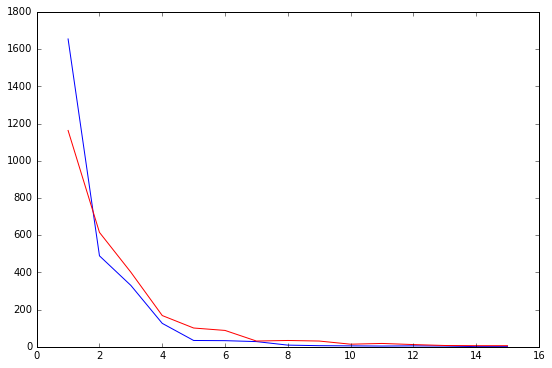

In [40]:
plt.plot([x+1 for x in range(15)], firstbycopies['docid'])
plt.plot(xs[0:15], ys[0:15], color = 'r')
plt.show()

Basically, the change we need to make is represented by the difference between the red and blue lines. We need to subtract about 500 titles that are only represented once, and add 500 titles that are represented by 2 -> copies.

In [44]:
needed = dict()
for i in range(2, 30):
    if i in firstbycopies.index:
        needed[i] = ys[i-1] - firstbycopies.loc[i, 'docid']
    else:
        needed[i] = ys[i-1]

add = 0
for i in range(2, 30):
    print(i, needed[i])
    add += needed[i]

print()   
print('remove:',firstbycopies.loc[1, 'docid'] - ys[0])
print('add: ', add)

2 126
3 71
4 42
5 67
6 55
7 3
8 25
9 25
10 9
11 14
12 7
13 3
14 6
15 5
16 4
17 0
18 3
19 2
20 4
21 3
22 0
23 1
24 3
25 2
26 3
27 0
28 2
29 0

remove: 492
add:  485


However, here's the rub: we want these additions and deletions to be evenly distributed across time, and we want the sampling to reflect local conditions in each decade. To achieve that, we're going to need to do everything we did above *in each decade.*

In [47]:
492 // 21

23

So, add 23 vols in each decade.

In [62]:
alreadysampled = set(first.docid)
selected = []

for decade_floor in range(1800, 2010, 10):
    dmeta = meta.loc[(meta.inferreddate >= decade_floor) & (meta.inferreddate < (decade_floor + 10)), : ]
    grouped = dmeta.groupby('copiesin25yrs')
    bycopies = grouped.agg({'docid': 'count'})
    
    # vols that can be selected
    toselect = dict()
    for numcopies, df in grouped:
        toselect[numcopies] = []
        for d in df.docid:
            if d not in alreadysampled:
                toselect[numcopies].append(d)
        random.shuffle(toselect[numcopies])
               
    totalcopies = []
    binlabels = []
    for idx, row in bycopies.iterrows():
        if idx == 1:
            continue
        else:
            binlabels.append(idx)
            
        copies = int(idx) * row['docid']
        totalcopies.append(copies)
    totalprob = np.array(totalcopies) / np.sum(totalcopies)

    cumulativeprob = []
    cumulate = 0
    
    for prob in totalprob:
        cumulate += prob
        cumulativeprob.append(cumulate)
        
    copycounts = []
    for i in range(0, 23):
        prob = random.uniform(0, 1)
        for label, threshold in zip(binlabels, cumulativeprob):
            if threshold > prob:
                copycounts.append(label)
                break

    for acount in copycounts:
        if len(toselect[acount]) > 0:
            chosen = toselect[acount].pop()
            selected.append(chosen)
        else:
            print('error')


error


In [63]:
len(selected)

482

In [64]:
thechosen = meta.loc[meta.docid.isin(selected), : ]
thechosen.to_csv('oft_reprinted.csv', index = False)

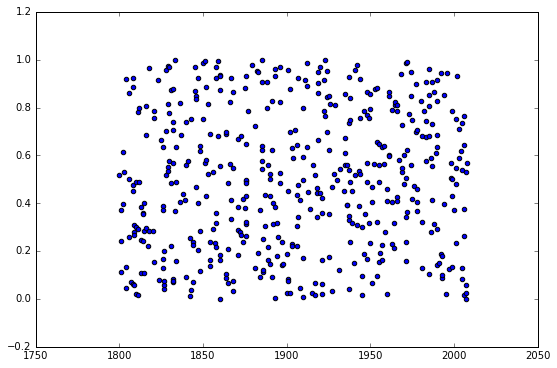

In [65]:
plt.scatter(thechosen.inferreddate, [random.uniform(0,1) for x in range(482)])

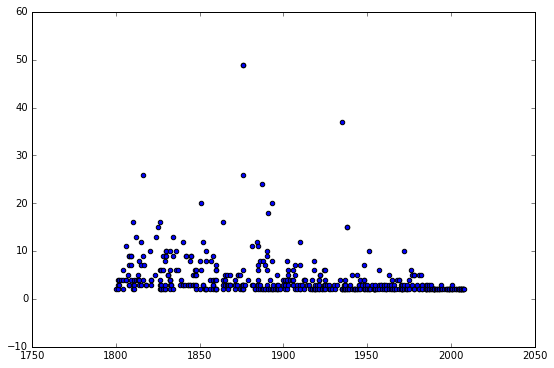

In [66]:
plt.scatter(thechosen.inferreddate, thechosen.copiesin25yrs)

Interesting relation to time.

In [68]:
random.shuffle(selected)

In [73]:
p = selected[0 : 200]
j = selected[200 : 400]
t = selected[400 : ]

In [74]:
p.extend(random.sample(j, 25))
p.extend(random.sample(t, 25))

In [75]:
j.extend(random.sample(p, 25))
j.extend(random.sample(t, 25))

In [76]:
t.extend(random.sample(p, 25))
t.extend(random.sample(j, 25))

In [81]:
patrick = pd.read_csv('patrick.tsv')
cols = patrick.columns
cols

Index(['docid', 'author', 'realname', 'pseudonym', 'gender', 'nationality',
       'authordate', 'inferreddate', 'firstpub', 'latestcomp',
       'allcopiesofwork', 'copiesin25yrs', 'enumcron', 'imprint', 'genres',
       'subjects', 'category', 'shorttitle'],
      dtype='object')

In [82]:
patrick = meta.loc[meta.docid.isin(p), cols]
patrick.shape

(250, 18)

In [84]:
patrick.to_csv('copies/patrickmanycopies.csv', index = False)

In [86]:
jessica = meta.loc[meta.docid.isin(j), cols]
jessica.to_csv('copies/jessicamanycopies.csv', index = False)

In [87]:
ted = meta.loc[meta.docid.isin(t), cols]
ted.to_csv('copies/tedmanycopies.csv', index = False)